# micrograd exercises

1. watch the [micrograd video](https://www.youtube.com/watch?v=VMj-3S1tku0) on YouTube
2. come back and complete these exercises to level up :)

## section 1: derivatives

In [123]:
# here is a mathematical expression that takes 3 inputs and produces one output
from math import sin, cos

def f(a, b, c):
  return -a**3 + sin(3*b) - 1.0/c + b**2.5 - a**0.5

print(f(2, 3, 4))

6.336362190988558


In [124]:
# write the function df that returns the analytical gradient of f
# i.e. use your skills from calculus to take the derivative, then implement the formula
# if you do not calculus then feel free to ask wolframalpha, e.g.:
# https://www.wolframalpha.com/input?i=d%2Fda%28sin%283*a%29%29%29

def gradf(a, b, c):
  df_da = -3 * (a**2) - 0.5 * (a**(-0.5))
  df_db = 3 * cos(3*b) + 2.5 * (b**1.5)
  df_dc = c**(-2)
  return [df_da, df_db, df_dc] # todo, return [df/da, df/db, df/dc]

# expected answer is the list of
ans = [-12.353553390593273, 10.25699027111255, 0.0625]
yours = gradf(2, 3, 4)
for dim in range(3):
  ok = 'OK' if abs(yours[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {yours[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353553390593273
OK for dim 1: expected 10.25699027111255, yours returns 10.25699027111255
OK for dim 2: expected 0.0625, yours returns 0.0625


In [128]:
# now estimate the gradient numerically without any calculus, using
# the approximation we used in the video.
# you should not call the function df from the last cell

# -----------
def num_grad_f(a, b, c, h):
  num_grad_a = (f(a + h, b, c) - f(a, b, c))/h
  num_grad_b = (f(a, b+h, c) - f(a, b, c))/h
  num_grad_c = (f(a, b, c+h) - f(a, b, c))/h
  return [num_grad_a, num_grad_b, num_grad_c]
h = 0.000001
numerical_grad = num_grad_f(2, 3, 4, h) # TODO
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353559348809995
OK for dim 1: expected 10.25699027111255, yours returns 10.256991666679482
OK for dim 2: expected 0.0625, yours returns 0.062499984743169534


In [131]:
# there is an alternative formula that provides a much better numerical
# approximation to the derivative of a function.
# learn about it here: https://en.wikipedia.org/wiki/Symmetric_derivative
# implement it. confirm that for the same step size h this version gives a
# better approximation.

# -----------
def num_grad_sym_f(a, b, c, h):
  num_grad_a = (f(a + h, b, c) - f(a-h, b, c))/(2*h)
  num_grad_b = (f(a, b+h, c) - f(a, b-h, c))/(2*h)
  num_grad_c = (f(a, b, c+h) - f(a, b, c-h))/(2*h)
  return [num_grad_a, num_grad_b, num_grad_c]
h = 0.001
numerical_grad2 = num_grad_sym_f(2, 3, 4, h) # TODO
# -----------

for dim in range(3):
  ok = 'OK' if abs(numerical_grad2[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {numerical_grad2[dim]}")


OK for dim 0: expected -12.353553390593273, yours returns -12.353554401639766
OK for dim 1: expected 10.25699027111255, yours returns 10.256994551617105
OK for dim 2: expected 0.0625, yours returns 0.06250000390650712


## section 2: support for softmax

In [12]:
import math

In [96]:
# Value class starter code, with many functions taken out
from math import exp, log

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def __add__(self, other): # exactly as in the video
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad

    out._backward = _backward

    return out

  def __pow__(self, other):
    if not isinstance(other, (int, float)):
      raise ValueError("power must be float or int")
    out = Value(self.data**other, (self, ), '**'+str(other))

    def _backward():
      self.grad += other*(self.data**(other-1))*out.grad
    out._backward = _backward

    return out

  def exp(self):
    out = Value(math.exp(self.data), (self,), 'exp')

    def _backward():
      self.grad += out.grad*out.data
    out._backward = _backward

    return out

  def log(self):
    out = Value(math.log(self.data), (self,), 'log')

    def _backward():
      self.grad += (1/self.data)*out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def relu(self):
    # print(self, self.data)
    xx = self.data
    r = (xx>0)*xx
    out = Value(r, (self,), 'relu')

    def _backward():
      self.grad += (xx>0)*out.grad
    out._backward = _backward

    return out



  # ------
  # re-implement all the other functions needed for the exercises below
  # your code here
  # TODO
  # ------

  def backward(self): # exactly as in video
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [9]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [13]:
# without referencing our code/video __too__ much, make this cell work
# you'll have to implement (in some cases re-implemented) a number of functions
# of the Value object, similar to what we've seen in the video.
# instead of the squared error loss this implements the negative log likelihood
# loss, which is very often used in classification.

# this is the softmax function
# https://en.wikipedia.org/wiki/Softmax_function
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  ok = 'OK' if abs(logits[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits[dim].grad}")


2.1755153626167147
OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400986


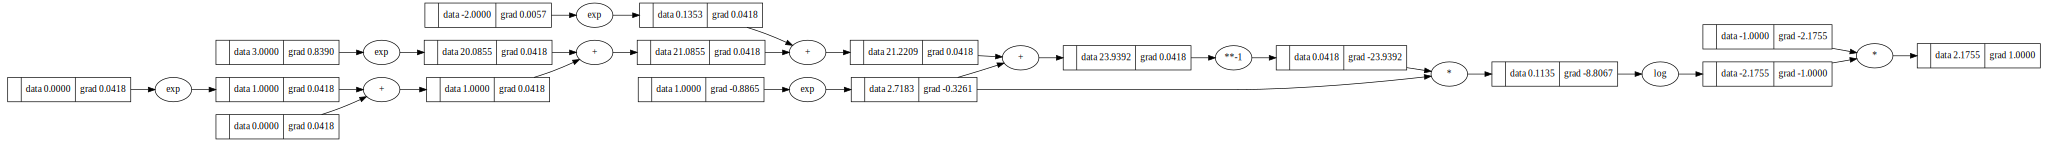

In [14]:
draw_dot(loss)

In [ ]:
# verify the gradient using the torch library
# torch should give you the exact same gradient
import torch

logits = torch.tensor([0.0, 3.0, -2.0, 1.0]).double(); logits.requires_grad = True

probs = torch.softmax(logits, 0, torch.double)
loss = -probs[3].log()
loss.backward()
print(loss.data)

for dim in range(4):
  ok = 'OK' if abs(logits.grad[dim] - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits.grad[dim]}")

tensor(2.1755, dtype=torch.float64)
OK for dim 0: expected 0.041772570515350445, yours returns 0.04177257051535046
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625321
OK for dim 2: expected 0.005653302662216329, yours returns 0.00565330266221633
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400987


The gradient calculated by torch is the same as we calculated using Value calss and micrograd.

#Simple Neural Net with Micrograd


In [71]:
import random

class Neuron:

  def __init__(self, nin, apply_act=True):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
    self.apply_act = apply_act

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    # activation function is relu
    if self.apply_act:
      out = act.relu()
    else:
      out = act

    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout, apply_act=True):
    self.neurons = [Neuron(nin, apply_act) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

To test the neural network and compare it with pytorch I will generate a simple 2 class classification dataset.

In [54]:
import numpy as np
import torch

# Number of samples per class
n_samples = 100

# Generate random data for two classes
class_0 = np.random.randn(n_samples, 3) + np.array([1, 1, 1])  # Class 0 centered around (1,1,1)
class_1 = np.random.randn(n_samples, 3) + np.array([-1, -1, -1])  # Class 1 centered around (-1,-1,-1)

# Combine the data
features = np.vstack((class_0, class_1))
labels = np.array([0]*n_samples + [1]*n_samples)

# Convert to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

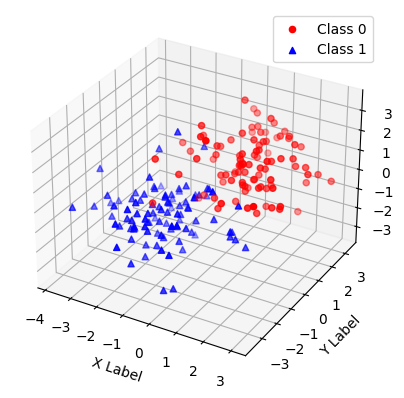

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'features' and 'labels' are defined as in the previous code snippet

# Convert to numpy arrays for plotting
features_np = features_tensor.numpy()
labels_np = labels_tensor.numpy()

# Create a new figure for 3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot class 0 points
ax.scatter(features_np[labels_np == 0, 0], features_np[labels_np == 0, 1], features_np[labels_np == 0, 2], c='r', marker='o', label='Class 0')

# Plot class 1 points
ax.scatter(features_np[labels_np == 1, 0], features_np[labels_np == 1, 1], features_np[labels_np == 1, 2], c='b', marker='^', label='Class 1')

# Label the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Legend
ax.legend()

# Show plot
plt.show()


## test on micrograd

In [85]:
# all neurons in out implementation have relu activation  but the last layer shouldn't have a relu
class Model:
  def __init__(self):
    self.mlp = MLP(3, [6, 4])
    self.last_layer = Layer(4, 2, apply_act=False)

  def __call__(self, x):
    # print('here1', x)
    x = self.mlp(x)
    # print('here2', x)
    x = self.last_layer(x)
    # print('here3', x)
    return x

  def parameters(self):
    return self.mlp.parameters() + self.last_layer.parameters()

In [81]:
def cross_entropy(pred, label):
  probs = softmax(pred)
  loss = -probs[int(label)].log()
  return loss

In [58]:
def zero_grad(model):
  for param in model.parameters():
    param.grad = 0.0

In [102]:
def sgd(model,  lr=0.01):
  for param in model.parameters():
    param.data -= lr*param.grad

In [116]:
features_mic = [[Value(i) for i in item] for item in features.tolist()]
labels_mic = labels.tolist()

model = Model()

In [117]:
# Training loop
for epoch in range(100):  # Number of epochs
    epoch_loss = 0
    for feature, label in zip(features_mic, labels_mic):
      # print(epoch, feature, label)
      zero_grad(model)
      out = model(feature)
      loss = cross_entropy(out, label)
      loss.backward()
      sgd(model)
      epoch_loss += loss.data
    epoch_loss /= len(labels)

    # Print statistics
    print(f'Epoch {epoch+1}, Loss: {loss.data}')

Epoch 1, Loss: 0.3357824788360629
Epoch 2, Loss: 0.5203985583825025
Epoch 3, Loss: 0.6666443003233705
Epoch 4, Loss: 0.7482094793927179
Epoch 5, Loss: 0.8378176469947616
Epoch 6, Loss: 0.8968040198320859
Epoch 7, Loss: 0.9435387570543291
Epoch 8, Loss: 0.9683597312181137
Epoch 9, Loss: 0.9804409729744425
Epoch 10, Loss: 0.9907517101482038
Epoch 11, Loss: 0.9899016761999899
Epoch 12, Loss: 0.9866977426255966
Epoch 13, Loss: 0.9828703839374285
Epoch 14, Loss: 0.9808300298735195
Epoch 15, Loss: 0.9684617219808686
Epoch 16, Loss: 0.9674333353516748
Epoch 17, Loss: 0.9689030357391446
Epoch 18, Loss: 0.9736371934256952
Epoch 19, Loss: 0.9948882306866291
Epoch 20, Loss: 0.9753811860255637
Epoch 21, Loss: 0.9666509399404547
Epoch 22, Loss: 0.9670978594893171
Epoch 23, Loss: 0.9628370636677492
Epoch 24, Loss: 0.9558373775421898
Epoch 25, Loss: 0.9514554559625605
Epoch 26, Loss: 0.9551790342792833
Epoch 27, Loss: 0.9435656626106957
Epoch 28, Loss: 0.9370459672789415
Epoch 29, Loss: 0.92718136576

In [118]:
# Function to calculate accuracy
def calculate_accuracy_mic(model, dataloader):
    total = len(labels_mic)
    correct = 0
    for feature, label in zip(features_mic, labels_mic):
            outputs = model(feature)
            predicted = int(outputs[0].data < outputs[1].data)
            correct += (predicted == label)

    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy
model_accuracy = calculate_accuracy_mic(model, dataloader)
print(f'Accuracy of the classifier: {model_accuracy:.2f}%')

Accuracy of the classifier: 94.00%


##test on pytorch


In [132]:
import torch.nn as nn
import torch.nn.functional as F

# Define the MLP model
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(3, 6)
        self.fc2 = nn.Linear(6, 4)
        self.fc3 = nn.Linear(4, 2)
        self.initialize_layers()

    def initialize_layers(self):
      nn.init.uniform_(self.fc1.weight, a=-1, b=1.0)
      nn.init.uniform_(self.fc1.bias, a=-1, b=1.0)

      nn.init.uniform_(self.fc2.weight, a=-1, b=1.0)
      nn.init.uniform_(self.fc2.bias, a=-1, b=1.0)

      nn.init.uniform_(self.fc3.weight, a=-1, b=1.0)
      nn.init.uniform_(self.fc3.bias, a=-1, b=1.0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the model
model_torch = SimpleMLP()



In [112]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Create a dataset and dataloader
dataset = TensorDataset(features_tensor, labels_tensor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_torch.parameters(), lr=0.01)

# Training loop
for epoch in range(100):  # Number of epochs
    epoch_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model_torch(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        epoch_loss += loss.item()
    epoch_loss/= len(dataloader)

    # Print statistics
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.5323507189750671
Epoch 2, Loss: 0.06878653913736343
Epoch 3, Loss: 0.39893820881843567
Epoch 4, Loss: 0.44707855582237244
Epoch 5, Loss: 0.044228434562683105
Epoch 6, Loss: 0.054458603262901306
Epoch 7, Loss: 0.04451614245772362
Epoch 8, Loss: 0.0015982723562046885
Epoch 9, Loss: 0.0004997196956537664
Epoch 10, Loss: 1.861182451248169
Epoch 11, Loss: 0.002506093354895711
Epoch 12, Loss: 0.054602302610874176
Epoch 13, Loss: 0.021992024034261703
Epoch 14, Loss: 0.46703195571899414
Epoch 15, Loss: 0.014872273430228233
Epoch 16, Loss: 0.2509313225746155
Epoch 17, Loss: 0.0006164796068333089
Epoch 18, Loss: 0.13313843309879303
Epoch 19, Loss: 1.1794323921203613
Epoch 20, Loss: 0.007304745726287365
Epoch 21, Loss: 5.364403477869928e-06
Epoch 22, Loss: 0.0005899119423702359
Epoch 23, Loss: 0.0008263748604804277
Epoch 24, Loss: 3.290122185717337e-05
Epoch 25, Loss: 0.11748544871807098
Epoch 26, Loss: 0.5497859120368958
Epoch 27, Loss: 0.00035565727739594877
Epoch 28, Loss: 0.0

In [115]:
# Function to calculate accuracy
def calculate_accuracy(model, dataloader):
    total = 0
    correct = 0
    with torch.no_grad():  # No need to track gradients for validation
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate accuracy
model_accuracy = calculate_accuracy(model_torch, dataloader)
print(f'Accuracy of the classifier: {model_accuracy:.2f}%')


Accuracy of the classifier: 95.00%
